In [1]:
import matplotlib.pyplot as plt
import numpy
import os
import pandas as pd
import requests
import sys
package_root_dir = os.path.join(os.getcwd(), "..")
sys.path.append(package_root_dir)

from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.models as models
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms.v2 as v2 
from torch.utils.data import DataLoader
import lightning as L

# utils/data_utils.py
from pandarallel import pandarallel
from functools import partial
from utils.data_utils import process_image_series

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


c:\Users\Owner\Documents\SillyProjects\FantAIno\scratch\..\utils\data_utils.py:45: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if img.format is 'PNG':
c:\Users\Owner\Documents\SillyProjects\FantAIno\scratch\..\utils\data_utils.py:47: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if img.mode is not 'RGBA':


# Mission Statement

Very simple starting objective. Get the album covers into a `torchvision.datasets.ImageFolder` to train up a simple proof-of-concept CNN to predict Fantano scores from album images.

In [2]:
# Load the data.
melondy_df_folder = os.path.join(package_root_dir, "data", "processed")
melondy_df = pd.read_csv(os.path.join(melondy_df_folder, "melondy.csv"))
melondy_df.head()

,artist,album,image_url,rating
0,G‐Eazy,When It's Dark Out,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,4
1,Joji,Nectar,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,6
2,Blonde Redhead,Penny Sparkle,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,8
3,Portishead,Dummy,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,10
4,Jack White,Fear of the Dawn,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,7


In [3]:
melondy_df.shape

(3276, 4)

<u>**NOTE**</u>: For consistency down the line to be able to stratify the training and test sets, I edited Fantano's review of Small Black's "New Chain" to be an 80 instead of his posted 81.

In [4]:
melondy_X, melondy_Y = melondy_df.drop(["rating"], axis=1), melondy_df["rating"]
melondy_X.head()

,artist,album,image_url
0,G‐Eazy,When It's Dark Out,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...
1,Joji,Nectar,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...
2,Blonde Redhead,Penny Sparkle,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...
3,Portishead,Dummy,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...
4,Jack White,Fear of the Dawn,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...


rating
 7     803
 8     716
 6     628
 5     450
 4     222
 3     131
 9     123
 10     90
 2      51
-1      39
 1      17
 0       6
Name: count, dtype: int64


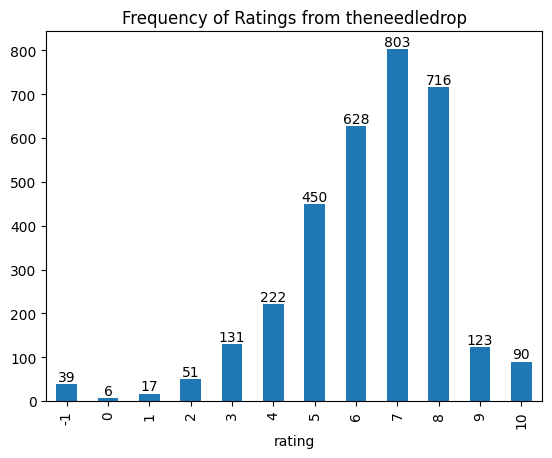

In [5]:
# Fantano's numerical rating distribution.
rating_counts = (melondy_Y).value_counts()
print(rating_counts)
ax = rating_counts.sort_index().plot(kind="bar")
plt.title("Frequency of Ratings from theneedledrop")

for container in ax.containers:
    ax.bar_label(container)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(melondy_X, melondy_Y, shuffle=True, random_state=0, test_size=0.2, stratify=melondy_Y)

In [7]:
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
training_data.head()

,artist,album,image_url,rating
1769,Frost Children,SPEED RUN,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,7
3107,Anderson .Paak,Ventura,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,7
1101,Model/Actriz,Dogsbody,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,8
29,SUMAC & Moor Mother,The Film,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,8
228,Mac Miller,Swimming,https://d1j3ls2jacen4o.cloudfront.net/thumbnai...,8


In [8]:
# parallel_apply requires top level functions (no lambdas) ONLY NEED TO DO ONCE
training_data.parallel_apply(partial(process_image_series, train=True), axis=1)
testing_data.parallel_apply(partial(process_image_series, train=False), axis=1)

2475    None
381     None
1396    None
1429    None
2286    None
        ... 
2185    None
2156    None
2456    None
1671    None
2741    None
Length: 656, dtype: object

In [14]:
number_of_album_images = sum([len(files) for r, d, files in os.walk(os.path.join(melondy_df_folder, "album_ImageFolder"))])
number_of_album_images

3276

In [15]:
melondy_album_dir = os.path.join(package_root_dir, "data", "processed", "album_ImageFolder")
test_image = Image.open(os.path.join(melondy_album_dir, "train", "-1", "4batz___u made me a st4r.jpg"))

In [16]:
test_image.size

(512, 512)

The below comment is the dense network I was using as part of a self crafted model that was one large convolutional block and then this dense block. For this exercise, I elected to go with the VGG16 architecture.

In [17]:
# # Add a decent FC block (fully connected layers) to predict the final ranking.
# # Flatten converts the output of the CNN into a 1D vector.
# torch.nn.Flatten(),
# # LazyLinear layers automatically infer the input size from the first forward pass.
# torch.nn.LazyLinear(512),
# # ReLU is a common activation function for neural networks.
# torch.nn.ReLU(),
# torch.nn.LazyLinear(256),
# torch.nn.ReLU(),
# torch.nn.LazyLinear(128),
# torch.nn.ReLU(),
# # The final layer outputs 12 values, corresponding to ratings 0-10 and a "NOT GOOD" category.
# torch.nn.LazyLinear(12), 

In [47]:
class DummyFantainoModel(L.LightningModule):

    def __init__(self):
        super().__init__()
        # Create the VGG16 model with pre-trained weights.
        # Using VGG16_Weights.DEFAULT ensures the latest recommended pre-trained weights are used.
        vgg16_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        
        # Freeze all parameters in the VGG16 model.
        # This prevents the pre-trained layers from being updated during training,
        # effectively using VGG16 as a fixed feature extractor.
        for param in vgg16_model.parameters():
            param.requires_grad = False
            
        self.model = torch.nn.Sequential(
            vgg16_model,
            # Add a decent FC block (fully connected layers) to predict the final ranking.
            # LazyLinear layers automatically infer the input size from the first forward pass.
            torch.nn.LazyLinear(512),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            # The final layer outputs 12 values: 0-10 and "NOT GOOD"
            torch.nn.LazyLinear(12), 
        )
        self.loss_function = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        prediction = self.model(x)
        return prediction

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        prediction_logits = self(x)
        loss = self.loss_function(prediction_logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        prediction_logits = self(x)
        loss = self.loss_function(prediction_logits, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        prediction_logits = self(x)
        loss = self.loss_function(prediction_logits, y)
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch  # Unpack the batch like in other methods
        return self(x)  # Pass only the images to the model


In [92]:
class FantAInoImageFolder(torchvision.datasets.ImageFolder):

    def __getitem__(self, index: int) -> tuple:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, os.path.basename(path)

    def find_classes(self, directory: str) -> tuple[list[str], dict[str, int]]:
        classes = sorted((entry.name for entry in os.scandir(directory) if entry.is_dir()), key=int)
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [93]:
# v2_transform = v2.Compose([
#     v2.Resize((128, 128)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True)
# ])

# preprocess the input
weights = models.VGG16_Weights.DEFAULT
preprocess = weights.transforms()

train_dataset = FantAInoImageFolder(root=os.path.join(melondy_album_dir, 'train'), transform=preprocess)
test_dataset = FantAInoImageFolder(root=os.path.join(melondy_album_dir, 'test'), transform=preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, persistent_workers=True)

In [20]:
model = DummyFantainoModel()
trainer = L.Trainer(max_epochs=5, accelerator="gpu", log_every_n_steps=1)
trainer.fit(model, train_dataloader, test_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Owner\Documents\SillyProjects\FantAIno\FantAIno\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Owner\Documents\SillyProjects\FantAIno\FantAIno\Lib\site-packages\lig

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [25]:
preds = trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.033902645111084
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [100]:
sample_test_x, sample_test_y, sample_test_path = test_dataset[0]
sample_test_path, sample_test_y

('AJR___Neotheater.jpg', 0)

In [102]:
# Add a batch dimension to the preprocessed image, as models typically expect inputs in batches.
input_tensor = preprocess(sample_test_x).unsqueeze(0)
prediction = model(input_tensor)
torch.round(torch.softmax(prediction, -1), decimals=2), sample_test_y

(tensor([[0.0100, 0.0000, 0.0000, 0.0100, 0.0000, 0.0300, 0.0500, 0.1800, 0.2500,
          0.2600, 0.2000, 0.0200]], grad_fn=<RoundBackward1>),
 0)

In [95]:
test_dataset.__getitem__(0)

(tensor([[[-1.6042, -1.5870, -1.5870,  ...,  0.9303,  0.9474,  0.9646],
          [-1.5870, -1.5699, -1.5699,  ...,  0.9132,  0.9474,  0.9817],
          [-1.5870, -1.6042, -1.6042,  ...,  0.8961,  0.9303,  0.9817],
          ...,
          [-0.3712, -0.4054, -0.4054,  ..., -0.5082, -1.4843, -1.0904],
          [-0.3883, -0.4226, -0.4226,  ..., -0.4226, -1.4843, -0.9192],
          [-0.4054, -0.4226, -0.4568,  ..., -0.7308, -0.9705, -0.9534]],
 
         [[-0.8102, -0.7752, -0.7752,  ...,  1.6583,  1.6933,  1.6933],
          [-0.7752, -0.7402, -0.7402,  ...,  1.6758,  1.6933,  1.7108],
          [-0.7577, -0.7752, -0.7752,  ...,  1.6408,  1.6758,  1.6933],
          ...,
          [ 0.7829,  0.7304,  0.7304,  ..., -0.3200, -1.3179, -0.9328],
          [ 0.7479,  0.6779,  0.6779,  ..., -0.2675, -1.3704, -0.7927],
          [ 0.7479,  0.7129,  0.6779,  ..., -0.5826, -0.7927, -0.7927]],
 
         [[ 0.4788,  0.4962,  0.4962,  ...,  2.3786,  2.3960,  2.3960],
          [ 0.5136,  0.5311,

In [96]:
test_dataset.find_classes(os.path.join(melondy_album_dir, 'test'))

(['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
 {'-1': 0,
  '0': 1,
  '1': 2,
  '2': 3,
  '3': 4,
  '4': 5,
  '5': 6,
  '6': 7,
  '7': 8,
  '8': 9,
  '9': 10,
  '10': 11})